In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, r2_score
import xgboost as xgb

In [2]:
data = pd.read_csv('Final_dataset.csv')

In [4]:
data['diff'] = data['diff'].apply(lambda x : abs(int(x.split()[0])))

In [5]:
data.head()

,accepted,citations,doc_id,rounds,year,author_id,degree_centrality,page_rank,cluster_coeff,closeness_centrality,betweenness_centrality,team_size,mean_citation,Author_Reputation,diff,Sentiment
0,1.0,0.0,25604.0,2.0,2014.0,13513.0,0.017833,0.000117,0.010757,0.409345,0.000255,3,22.700000,1.0,41,0.121670
1,1.0,0.0,25604.0,2.0,2014.0,21593.0,0.004161,0.000033,0.023025,0.357497,0.000007,3,3.600000,1.0,41,0.121670
2,1.0,0.0,25604.0,2.0,2014.0,4302.0,0.036472,0.000247,0.008988,0.427258,0.000581,3,15.608696,1.0,41,0.121670
3,1.0,15.0,14964.0,2.0,2010.0,13513.0,0.017833,0.000117,0.010757,0.409345,0.000255,3,22.700000,1.0,19,0.433333
4,1.0,15.0,14964.0,2.0,2010.0,13513.0,0.017833,0.000117,0.010757,0.409345,0.000255,3,22.700000,1.0,0,0.433333


In [6]:
def in_qrange(ser, q):
    return ser.between(*ser.quantile(q=q))

### Author Popularity

In [16]:
bottom25 =  data.loc[data['mean_citation'].transform(in_qrange, q=[0, 0.25])]
top25 =  data.loc[data['mean_citation'].transform(in_qrange, q=[0.75, 1])]

In [17]:
bottom25.citations.mean(),top25.citations.mean()

(4.81144451145959, 68.32874008275444)

### Author Reputation

In [18]:
bottom25 =  data.loc[data['Author_Reputation'].transform(in_qrange, q=[0, 0.25])]
top25 =  data.loc[data['Author_Reputation'].transform(in_qrange, q=[0.75, 1])]

In [19]:
bottom25.citations.mean(),top25.citations.mean()

(16.2837648307494, 32.040872111942726)

### Team Size

In [40]:
bottom25 =  data.loc[data['team_size'].transform(in_qrange, q=[0.8, 0.9])]
top25 =  data.loc[data['team_size'].transform(in_qrange, q=[0, .2])]

In [41]:
bottom25.citations.mean(),top25.citations.mean()

(49.53358843537415, 21.525056831676448)

### Report Sentiments

In [47]:
bottom25 =  data.loc[data['Sentiment'].transform(in_qrange, q=[0, 0.1])]
top25 =  data.loc[data['Sentiment'].transform(in_qrange, q=[0.9, 1])]

In [48]:
bottom25.citations.mean(),top25.citations.mean()

(54.579338842975204, 24.172974488365572)

### Delay in Reports

In [53]:
bottom25 =  data.loc[data['diff'].transform(in_qrange, q=[0, 0.25])]
top25 =  data.loc[data['diff'].transform(in_qrange, q=[0.75, 1])]

In [54]:
bottom25.citations.mean(),top25.citations.mean()

(27.5711004235159, 28.95560184170138)

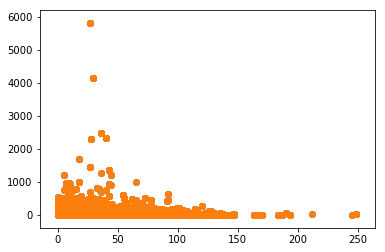

In [56]:
plt.scatter(data['diff'],data['citations'])
plt.show()

In [57]:
features = data.drop(['doc_id','citations'],axis=1).columns.tolist()
target = 'citations'

In [58]:
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [59]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
mean_citation vs citations,0.635586
year vs citations,-0.199613
author_id vs citations,-0.123728
Sentiment vs citations,-0.123420
Author_Reputation vs citations,0.096583
accepted vs citations,0.080455
cluster_coeff vs citations,-0.040726
page_rank vs citations,0.037693
rounds vs citations,-0.037467
team_size vs citations,-0.032859


In [60]:
regr = linear_model.LinearRegression()
new_data = data.drop('citations',axis=1)

In [61]:
X = new_data
y = data.citations

In [62]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

In [63]:
regr.fit(X_train.drop('doc_id',axis=1), y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
r2_score(regr.predict(X_test.drop('doc_id',axis=1)),y_test)

-0.8613999500728926

In [65]:
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test.drop('doc_id',axis=1)) - y_test) ** 2)))

RMSE: 55.64


In [106]:
xgb_model = xgb.XGBRegressor()
para ={
    'colsample_bytree': 0.8,
    'learning_rate': .4,
    'max_depth': 30,
    'min_child_weight': 3,
    'n_estimators': 1000,
    'n_jobs': -1,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'seed': 1337,
    'silent': 0,
    'subsample': 0.9,
    'booster':'gbtree' ,
    'tree_method ':'exact'
    }


In [107]:
n_rounds = 50
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
bst = xgb.train(para, dtrain,n_rounds)
y_pred = bst.predict(dtest)

In [108]:
print(r2_score(y_test,y_pred))

0.7311367725504485


In [72]:
data.shape

(105344, 16)